# Quaternion Loss Function

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

import pandas as pd
from scipy.optimize import minimize
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import random_split
from torch.nn.functional import normalize

from ahrs.filters.madgwick import Madgwick
from ahrs.filters.mahony import Mahony
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

file_path = '/home/asp/Downloads/AML/final-project/a000_1/data.hdf5'

def plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size, filename=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Loss: {loss.item():.4f}, dist_metric: {dist_metric}, agg_type: {agg_type}, normalize: {normal}', fontsize=16)

    legend_elements = [Patch(facecolor='orange', label='Predictions on train data'),
                        Patch(facecolor='red', label='Predictions on test data'),
                        Patch(facecolor='green', label='Orientation from Tango')]

    for i, title in enumerate(['x', 'y', 'z', 'w']):
        ax[i//2, i%2].xaxis.set_minor_locator(AutoMinorLocator())
        ax[i//2, i%2].yaxis.set_minor_locator(AutoMinorLocator())
        if np.linalg.norm(predictions-tango_ori) > np.linalg.norm(predictions+tango_ori):
            predictions = -predictions
        ax[i//2, i%2].plot(time[:train_size], predictions[:train_size, i], color='orange')
        ax[i//2, i%2].plot(time[train_size:], predictions[train_size:, i], color='red')
        ax[i//2, i%2].plot(time, tango_ori[:, i], color='green')
        ax[i//2, i%2].set_title(f'Orientation {title}')
        ax[i//2, i%2].set_ylim([-1, 1])
        ax[i//2, i%2].set_ylabel('Orientation')
        ax[i//2, i%2].set_xlabel('Time')
        ax[i//2, i%2].grid(True, which='both')
        ax[i//2, i%2].grid(which='minor', alpha=0.2, linestyle='--')
        ax[i//2, i%2].grid(which='major', alpha=0.5)
        legend = ax[i//2, i%2].legend(handles=legend_elements, title="Legend", loc='upper left', title_fontsize='medium', fontsize='small')
        legend.get_frame().set_facecolor('lightgrey')
        legend.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi = 400)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()

In [2]:
if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data
data_dict = load_data(file_path, verbose=True)

N = 20000

if N == 0:
    ekf_ori = data_dict['pose/ekf_ori']
    tango_ori = data_dict['pose/tango_ori']
    gyro = data_dict['synced/gyro']
    gyro_uncalib = data_dict['synced/gyro_uncalib']
    acc = data_dict['synced/acce']
    linacc = data_dict['synced/linacce']
    mag = data_dict['synced/magnet']
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time']
    rv = data_dict['synced/rv']
    game_rv = data_dict['synced/game_rv']
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

else:
    ekf_ori = data_dict['pose/ekf_ori'][:N]
    tango_ori = data_dict['pose/tango_ori'][:N]
    gyro = data_dict['synced/gyro'][:N]
    gyro_uncalib = data_dict['synced/gyro_uncalib'][:N]
    acc = data_dict['synced/acce'][:N]
    linacc = data_dict['synced/linacce'][:N]
    mag = data_dict['synced/magnet'][:N]
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time'][:N]
    rv = data_dict['synced/rv'][:N]
    game_rv = data_dict['synced/game_rv'][:N]
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori
		 
	 tango_ori
		 
	 tango_pos
		 
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce
		 
	 game_rv
		 
	 grav
		 
	 gyro
		 
	 gyro_uncalib
		 
	 linacce
		 
	 magnet
		 
	 rv
		 
	 time
		 


In [3]:
gain = 1.12666016
madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q


k_P = 0.5366640716587453
k_I = 0.4086550384556218
mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q


acc_var = 0.3**2
gyro_var = 0.5**2
mag_var = 0.8**2
ekf = EKF(gyr=gyro, acc=acc, mag=mag, dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q


if not torch.is_tensor(gyro):
    gyro = torch.from_numpy(gyro).float()
if not torch.is_tensor(acc):
    acc = torch.from_numpy(acc).float()
if not torch.is_tensor(mag):
    mag = torch.from_numpy(mag).float()
if not torch.is_tensor(rv):
    rv = torch.from_numpy(rv).float()
if not torch.is_tensor(game_rv):
    game_rv = torch.from_numpy(game_rv).float()
if not torch.is_tensor(Q_1):
    Q_1 = torch.from_numpy(Q_1).float()
if not torch.is_tensor(Q_2):
    Q_2 = torch.from_numpy(Q_2).float()
if not torch.is_tensor(Q_ekf):
    Q_ekf = torch.from_numpy(Q_ekf).float()
if not torch.is_tensor(tango_ori):
    tango_ori = torch.from_numpy(tango_ori).float()

In [4]:
class LSTMOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])
        
        return out

class CustomLoss(nn.Module):
    def __init__(self, dist_metric='phi2', agg_type='L2', normal=False):
        super().__init__()
        self.dist_metric = dist_metric
        self.agg_type = agg_type
        self.normal = normal

    def forward(self, q1, q2):
        if self.normal:
            q1 = self.normalize(q1)
            q2 = self.normalize(q2)
        if self.dist_metric == 'phi2':
            return self.phi2(q1, q2)
        elif self.dist_metric == 'phi4':
            return self.phi4(q1, q2)
        elif self.dist_metric == 'phi5':
            return self.phi5(q1, q2)
        else:
            raise ValueError('Invalid distance metric')

    def phi2(self, q1, q2):
        return self.aggregate(torch.min(torch.norm(q1 - q2), torch.norm(q1 + q2)))

    def phi4(self, q1, q2):
        return self.aggregate(1 - torch.abs(torch.einsum('ij,ij->i', q1, q2)))

    def phi5(self, q1, q2):
        R1 = self.quat_to_rot(q1)
        R2 = self.quat_to_rot(q2)
        return self.aggregate(torch.norm(torch.eye(3, device=q1.device)[None, :, :] - torch.bmm(R1, R2.transpose(-2, -1)), p='fro'))

    def quat_to_rot(self, q):
        q = self.normalize(q)

        q_r, q_i, q_j, q_k = q.split(1, dim=-1)
        q_r, q_i, q_j, q_k = q_r.squeeze(-1), q_i.squeeze(-1), q_j.squeeze(-1), q_k.squeeze(-1)

        R = torch.zeros((*q.shape[:-1], 3, 3), device=q.device)
        R[..., 0, 0] = 1 - 2 * (q_j ** 2 + q_k ** 2)
        R[..., 0, 1] = 2 * (q_i * q_j - q_k * q_r)
        R[..., 0, 2] = 2 * (q_i * q_k + q_j * q_r)
        R[..., 1, 0] = 2 * (q_i * q_j + q_k * q_r)
        R[..., 1, 1] = 1 - 2 * (q_i ** 2 + q_k ** 2)
        R[..., 1, 2] = 2 * (q_j * q_k - q_i * q_r)
        R[..., 2, 0] = 2 * (q_i * q_k - q_j * q_r)
        R[..., 2, 1] = 2 * (q_j * q_k + q_i * q_r)
        R[..., 2, 2] = 1 - 2 * (q_i ** 2 + q_j ** 2)

        return R
    
    def normalize(self, q):
        return q / torch.norm(q, dim=-1, keepdim=True)

    def aggregate(self, x):
        if self.agg_type == 'L1':
            return torch.mean(torch.abs(x))
        elif self.agg_type == 'L2':
            return torch.mean(x ** 2)
        elif self.agg_type == 'log':
            return -torch.mean(torch.log(x))
        else:
            raise ValueError('Invalid aggregation type')

input_size = 21
hidden_size = 128
num_layers = 3
output_size = 4
num_epochs = 20
learning_rate = 0.01
weight_decay = 0.0035
seq_len = 5
betas = (0.66, 0.96)
amsgrad = True

parameters = {
    'optimizer': 'AdamW',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'seq_len': seq_len,
    'betas': betas,
    'amsgrad': True,
}

Epoch 1/20, Train Loss: 125.0305, Validation Loss: 41.5163
Epoch 2/20, Train Loss: 89.6833, Validation Loss: 70.1758
Epoch 3/20, Train Loss: 170.1222, Validation Loss: 53.6813
Epoch 4/20, Train Loss: 88.1177, Validation Loss: 49.4963
Epoch 5/20, Train Loss: 82.4085, Validation Loss: 49.7075
Epoch 6/20, Train Loss: 74.8088, Validation Loss: 43.1934
Epoch 7/20, Train Loss: 61.7624, Validation Loss: 35.9519
Epoch 8/20, Train Loss: 53.4266, Validation Loss: 26.7556
Epoch 9/20, Train Loss: 51.6313, Validation Loss: 27.4514
Epoch 10/20, Train Loss: 46.5436, Validation Loss: 33.2568
Epoch 11/20, Train Loss: 44.3867, Validation Loss: 27.3406
Epoch 12/20, Train Loss: 44.1660, Validation Loss: 29.4245
Epoch 13/20, Train Loss: 42.6684, Validation Loss: 28.1807
Epoch 14/20, Train Loss: 45.7492, Validation Loss: 28.2370
Epoch 15/20, Train Loss: 35.4259, Validation Loss: 24.0685
Epoch 16/20, Train Loss: 39.1781, Validation Loss: 28.7815
Epoch 17/20, Train Loss: 36.2783, Validation Loss: 26.7327
Epoc

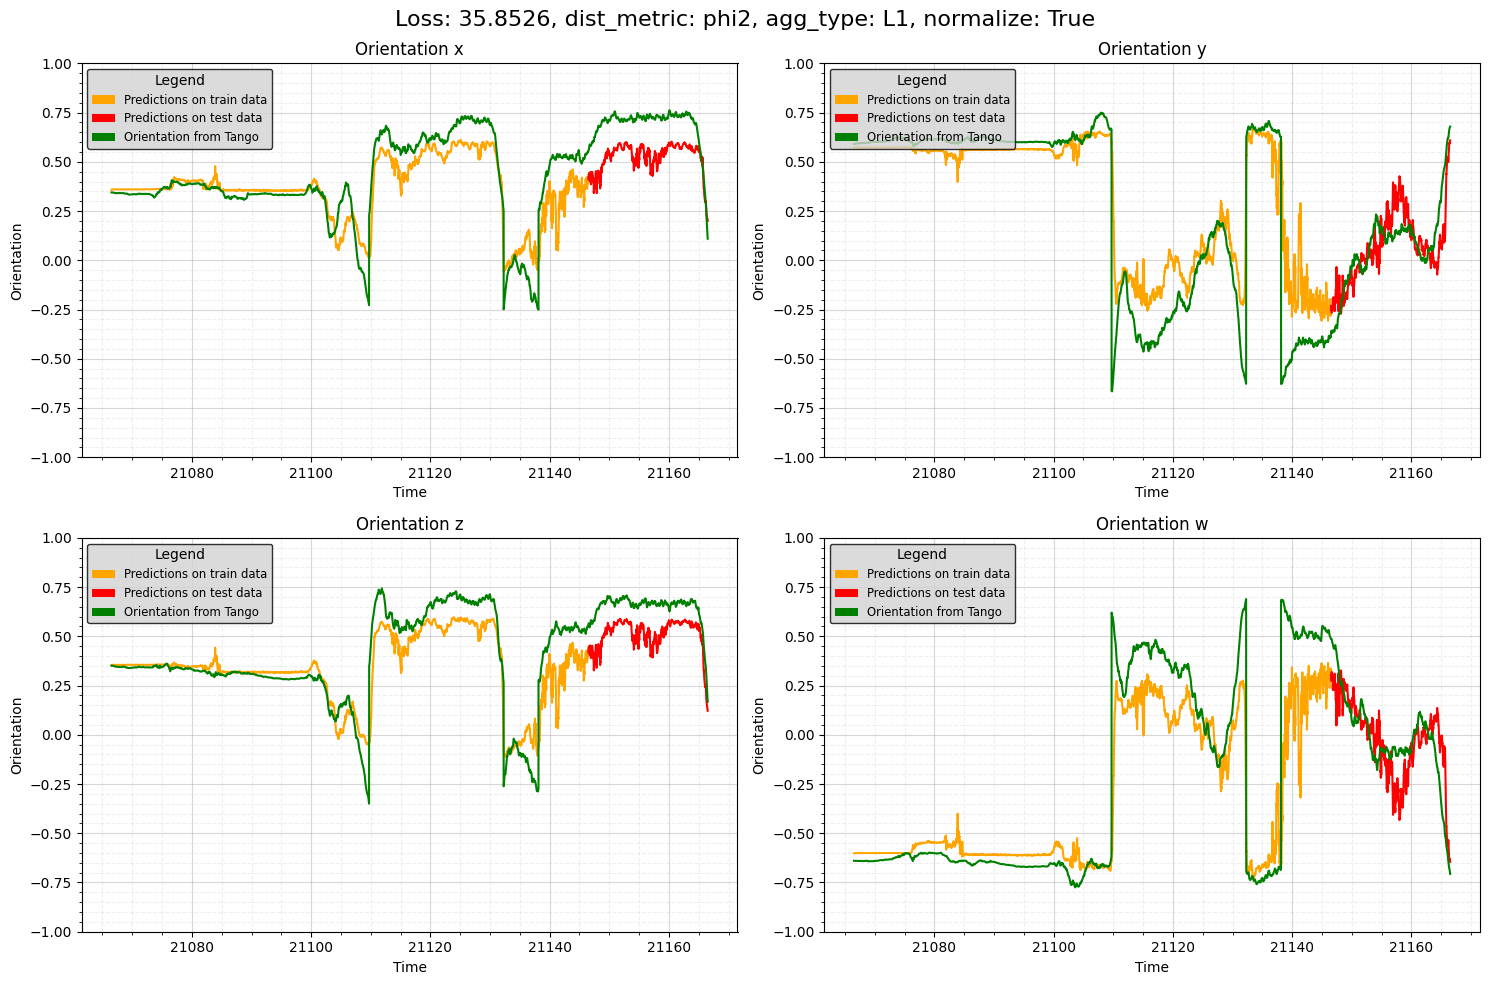

Epoch 1/20, Train Loss: 122.7210, Validation Loss: 41.7464
Epoch 2/20, Train Loss: 92.1557, Validation Loss: 66.5075
Epoch 3/20, Train Loss: 151.8060, Validation Loss: 48.8450
Epoch 4/20, Train Loss: 73.1721, Validation Loss: 53.9276
Epoch 5/20, Train Loss: 84.2649, Validation Loss: 46.7974
Epoch 6/20, Train Loss: 68.8778, Validation Loss: 41.3998
Epoch 7/20, Train Loss: 58.2824, Validation Loss: 31.8041
Epoch 8/20, Train Loss: 52.4301, Validation Loss: 25.6266
Epoch 9/20, Train Loss: 50.1630, Validation Loss: 29.9035
Epoch 10/20, Train Loss: 44.7656, Validation Loss: 33.0508
Epoch 11/20, Train Loss: 42.4048, Validation Loss: 28.9878
Epoch 12/20, Train Loss: 39.2635, Validation Loss: 23.2304
Epoch 13/20, Train Loss: 39.2858, Validation Loss: 26.8888
Epoch 14/20, Train Loss: 50.1446, Validation Loss: 25.0431
Epoch 15/20, Train Loss: 35.8589, Validation Loss: 20.9507
Epoch 16/20, Train Loss: 31.5799, Validation Loss: 20.9111
Epoch 17/20, Train Loss: 33.9140, Validation Loss: 19.8145
Epoc

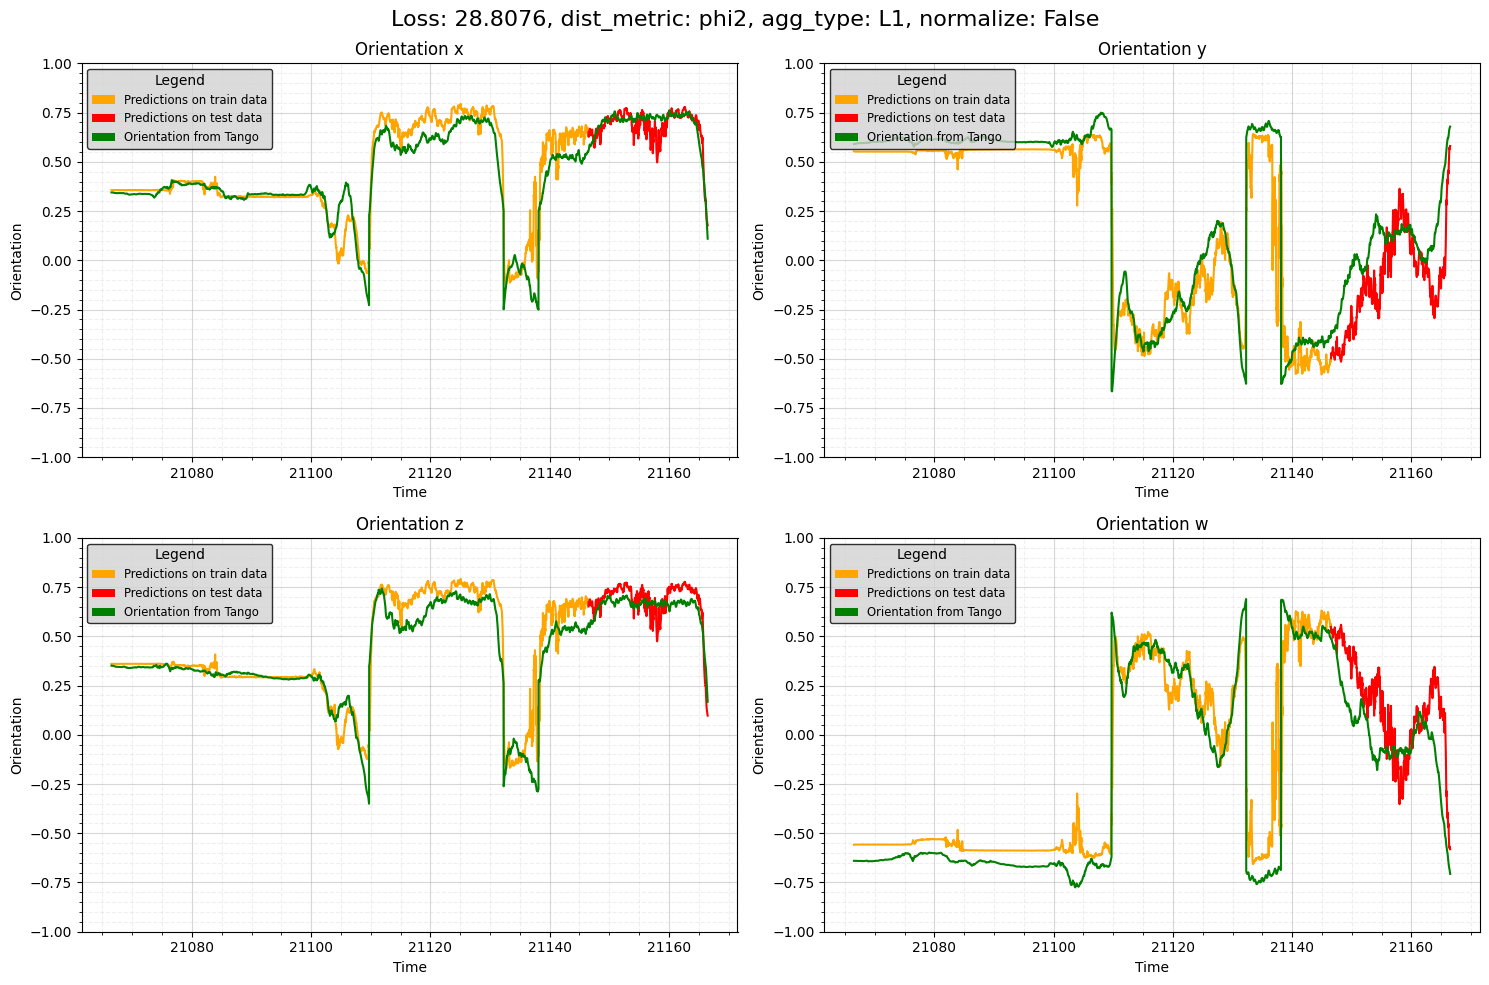

Epoch 1/20, Train Loss: 15968.0898, Validation Loss: 988.9835
Epoch 2/20, Train Loss: 9020.4316, Validation Loss: 4818.2949
Epoch 3/20, Train Loss: 18062.0176, Validation Loss: 3482.0396
Epoch 4/20, Train Loss: 9757.9648, Validation Loss: 2388.9688
Epoch 5/20, Train Loss: 7280.0034, Validation Loss: 2004.6716
Epoch 6/20, Train Loss: 5534.1763, Validation Loss: 1717.2867
Epoch 7/20, Train Loss: 3380.9009, Validation Loss: 1393.8275
Epoch 8/20, Train Loss: 2964.6294, Validation Loss: 714.1215
Epoch 9/20, Train Loss: 2551.3149, Validation Loss: 680.4439
Epoch 10/20, Train Loss: 2191.8984, Validation Loss: 970.3761
Epoch 11/20, Train Loss: 1942.9463, Validation Loss: 795.6387
Epoch 12/20, Train Loss: 1641.0238, Validation Loss: 628.4669
Epoch 13/20, Train Loss: 1841.7455, Validation Loss: 899.6031
Epoch 14/20, Train Loss: 2066.8359, Validation Loss: 646.6743
Epoch 15/20, Train Loss: 1662.2623, Validation Loss: 514.8108
Epoch 16/20, Train Loss: 1215.9363, Validation Loss: 581.4337
Epoch 17/

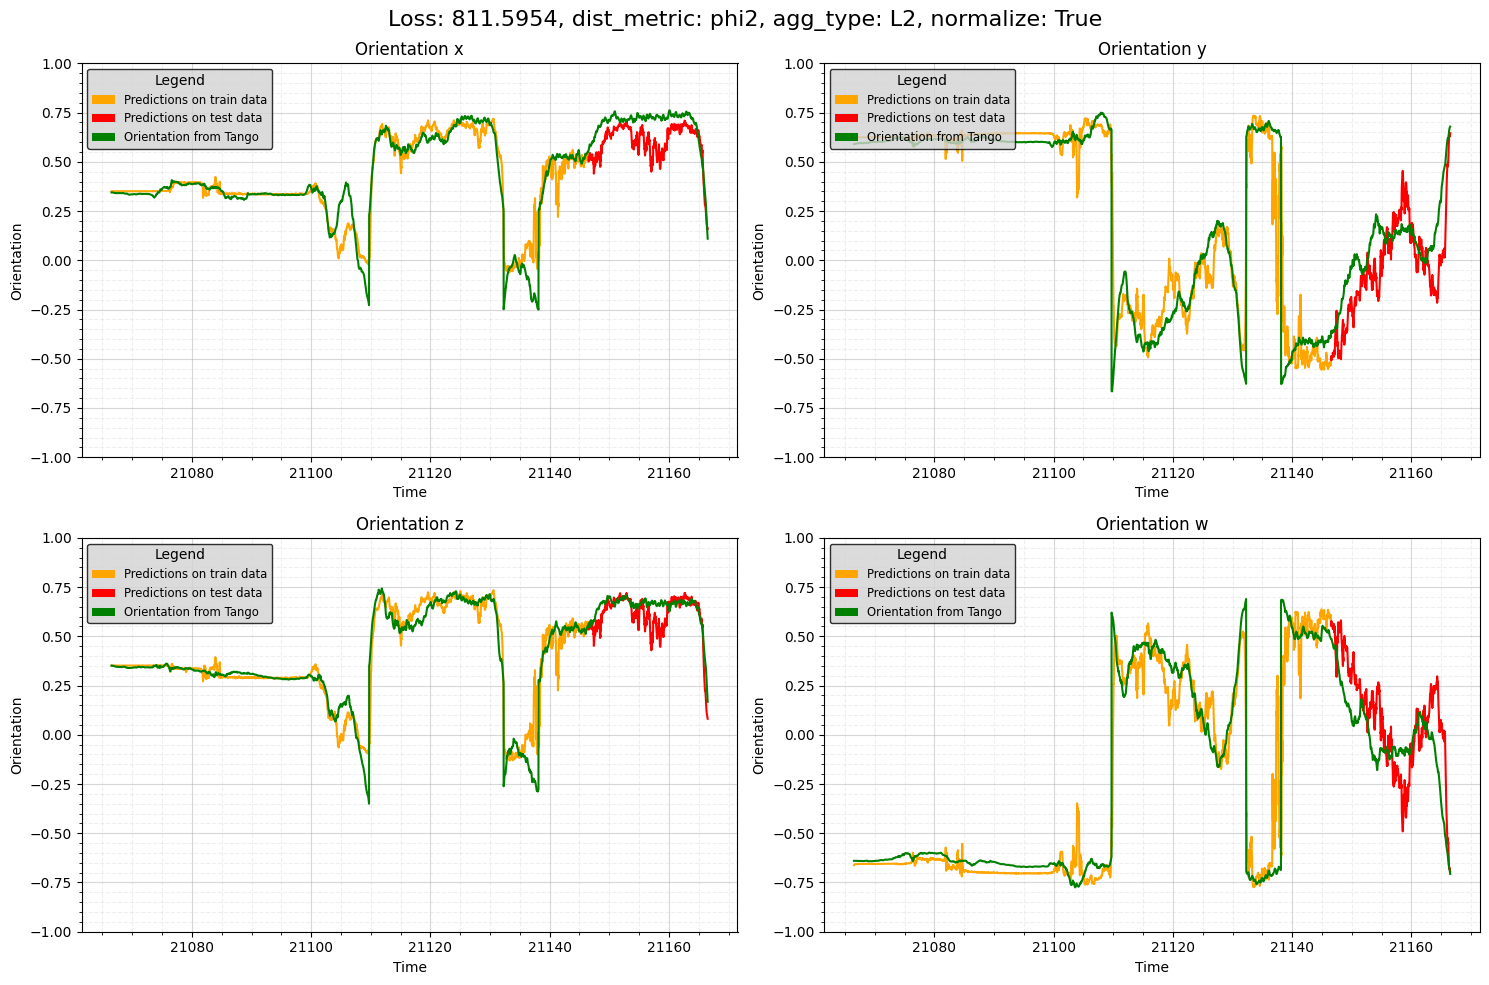

Epoch 1/20, Train Loss: 15012.6807, Validation Loss: 1453.8030
Epoch 2/20, Train Loss: 8438.2207, Validation Loss: 5886.2466
Epoch 3/20, Train Loss: 27793.4629, Validation Loss: 3038.0242
Epoch 4/20, Train Loss: 8896.0850, Validation Loss: 2480.2917
Epoch 5/20, Train Loss: 7547.1860, Validation Loss: 2076.9050
Epoch 6/20, Train Loss: 5473.9111, Validation Loss: 1948.8016
Epoch 7/20, Train Loss: 4609.0571, Validation Loss: 1438.3513
Epoch 8/20, Train Loss: 3076.6235, Validation Loss: 889.8574
Epoch 9/20, Train Loss: 2489.2854, Validation Loss: 608.9505
Epoch 10/20, Train Loss: 2543.8359, Validation Loss: 795.8404
Epoch 11/20, Train Loss: 2008.5133, Validation Loss: 976.7925
Epoch 12/20, Train Loss: 1804.7588, Validation Loss: 810.1436
Epoch 13/20, Train Loss: 1592.2129, Validation Loss: 623.7704
Epoch 14/20, Train Loss: 1437.3795, Validation Loss: 563.9124
Epoch 15/20, Train Loss: 1229.9276, Validation Loss: 596.5690
Epoch 16/20, Train Loss: 1149.2415, Validation Loss: 407.3202
Epoch 17

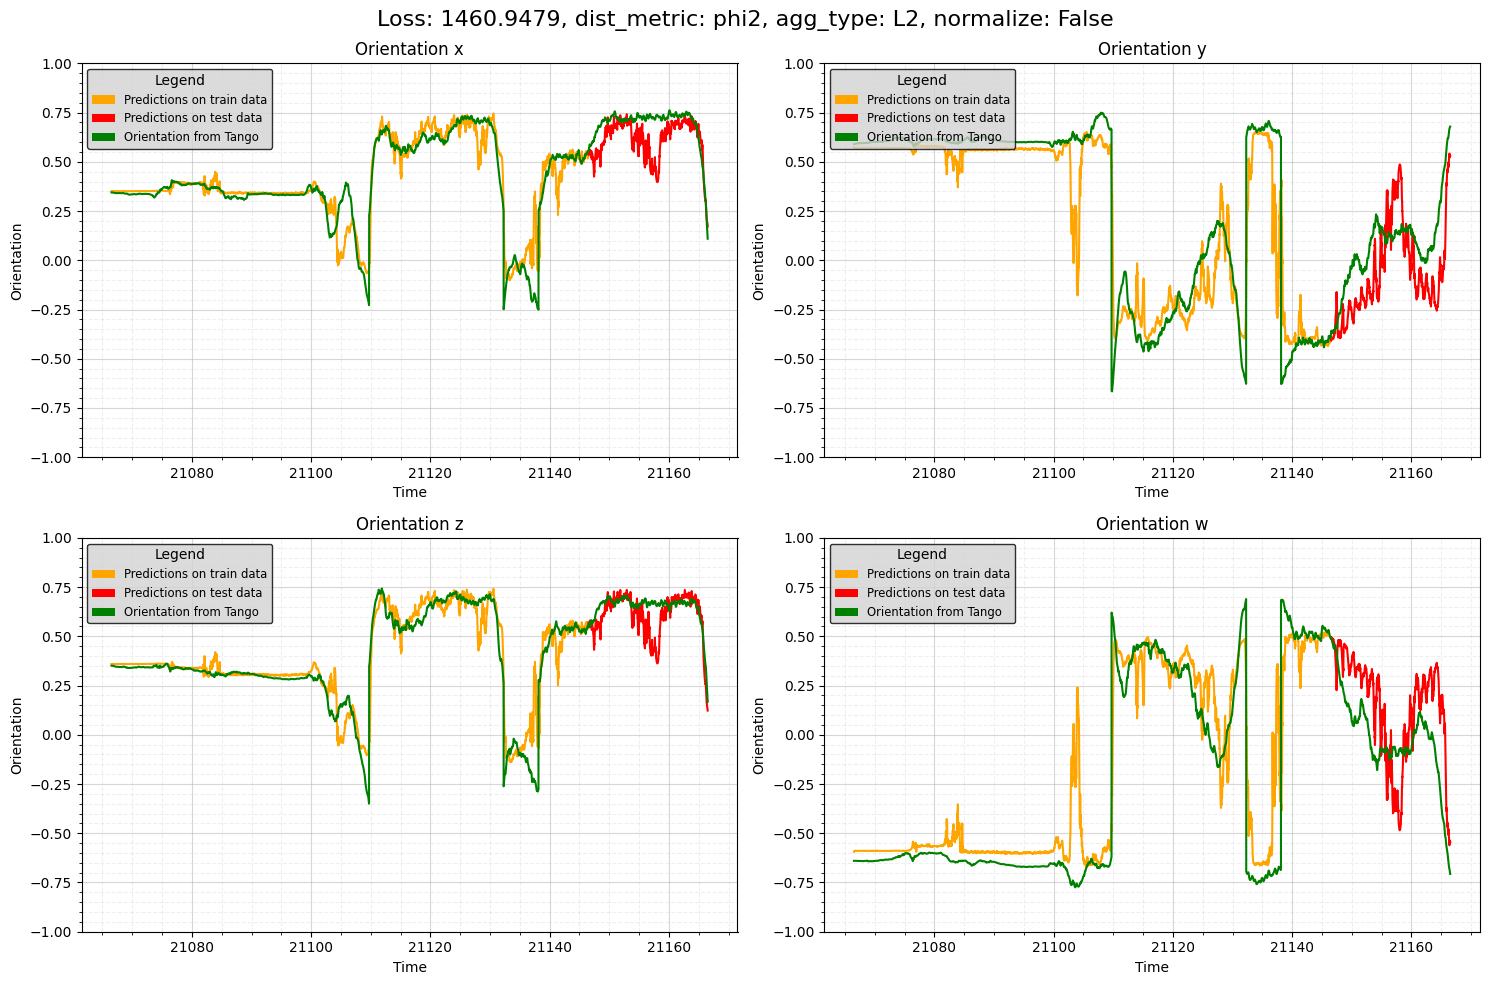

Epoch 1/20, Train Loss: 0.9573, Validation Loss: 0.4362
Epoch 2/20, Train Loss: 0.6089, Validation Loss: 1.7200
Epoch 3/20, Train Loss: 1.0062, Validation Loss: 0.2685
Epoch 4/20, Train Loss: 0.2523, Validation Loss: 0.3190
Epoch 5/20, Train Loss: 0.3635, Validation Loss: 0.2167
Epoch 6/20, Train Loss: 0.4073, Validation Loss: 0.1672
Epoch 7/20, Train Loss: 0.2756, Validation Loss: 0.1674
Epoch 8/20, Train Loss: 0.2431, Validation Loss: 0.1223
Epoch 9/20, Train Loss: 0.1660, Validation Loss: 0.3525
Epoch 10/20, Train Loss: 0.1854, Validation Loss: 0.2480
Epoch 11/20, Train Loss: 0.1110, Validation Loss: 0.2709
Epoch 12/20, Train Loss: 0.2435, Validation Loss: 0.2028
Epoch 13/20, Train Loss: 0.1897, Validation Loss: 0.1032
Epoch 14/20, Train Loss: 0.1735, Validation Loss: 0.0951
Epoch 15/20, Train Loss: 0.0860, Validation Loss: 0.1414
Epoch 16/20, Train Loss: 0.1080, Validation Loss: 0.0541
Epoch 17/20, Train Loss: 0.1054, Validation Loss: 0.1456
Epoch 18/20, Train Loss: 0.1135, Validat

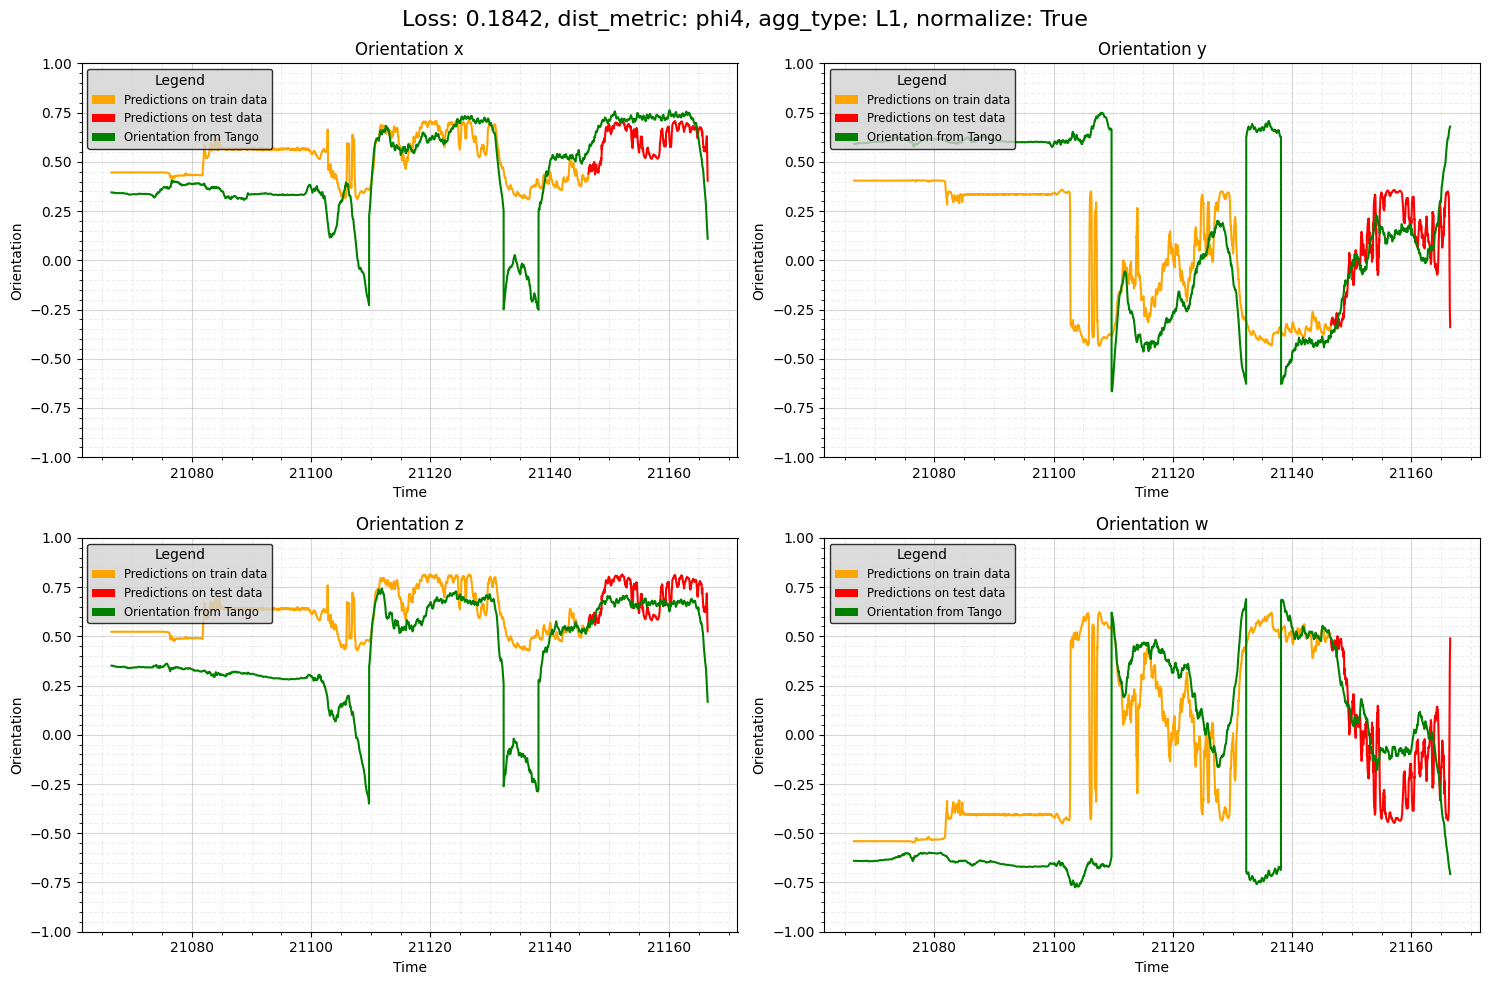

Epoch 1/20, Train Loss: 0.9598, Validation Loss: 0.6663
Epoch 2/20, Train Loss: 0.6191, Validation Loss: 0.6637
Epoch 3/20, Train Loss: 1.0194, Validation Loss: 0.2264
Epoch 4/20, Train Loss: 0.3032, Validation Loss: 0.3192
Epoch 5/20, Train Loss: 0.4140, Validation Loss: 0.5685
Epoch 6/20, Train Loss: 0.3973, Validation Loss: 0.3942
Epoch 7/20, Train Loss: 0.2146, Validation Loss: 0.2308
Epoch 8/20, Train Loss: 0.1918, Validation Loss: 0.2463
Epoch 9/20, Train Loss: 0.2770, Validation Loss: 0.1325
Epoch 10/20, Train Loss: 0.1776, Validation Loss: 0.4266
Epoch 11/20, Train Loss: 0.2374, Validation Loss: 0.3771
Epoch 12/20, Train Loss: 0.1508, Validation Loss: 0.0921
Epoch 13/20, Train Loss: 0.1757, Validation Loss: 0.1153
Epoch 14/20, Train Loss: 0.2201, Validation Loss: 0.2266
Epoch 15/20, Train Loss: 0.1386, Validation Loss: 0.3806
Epoch 16/20, Train Loss: 0.1071, Validation Loss: 0.1719
Epoch 17/20, Train Loss: 0.0873, Validation Loss: 0.1597
Epoch 18/20, Train Loss: 0.1039, Validat

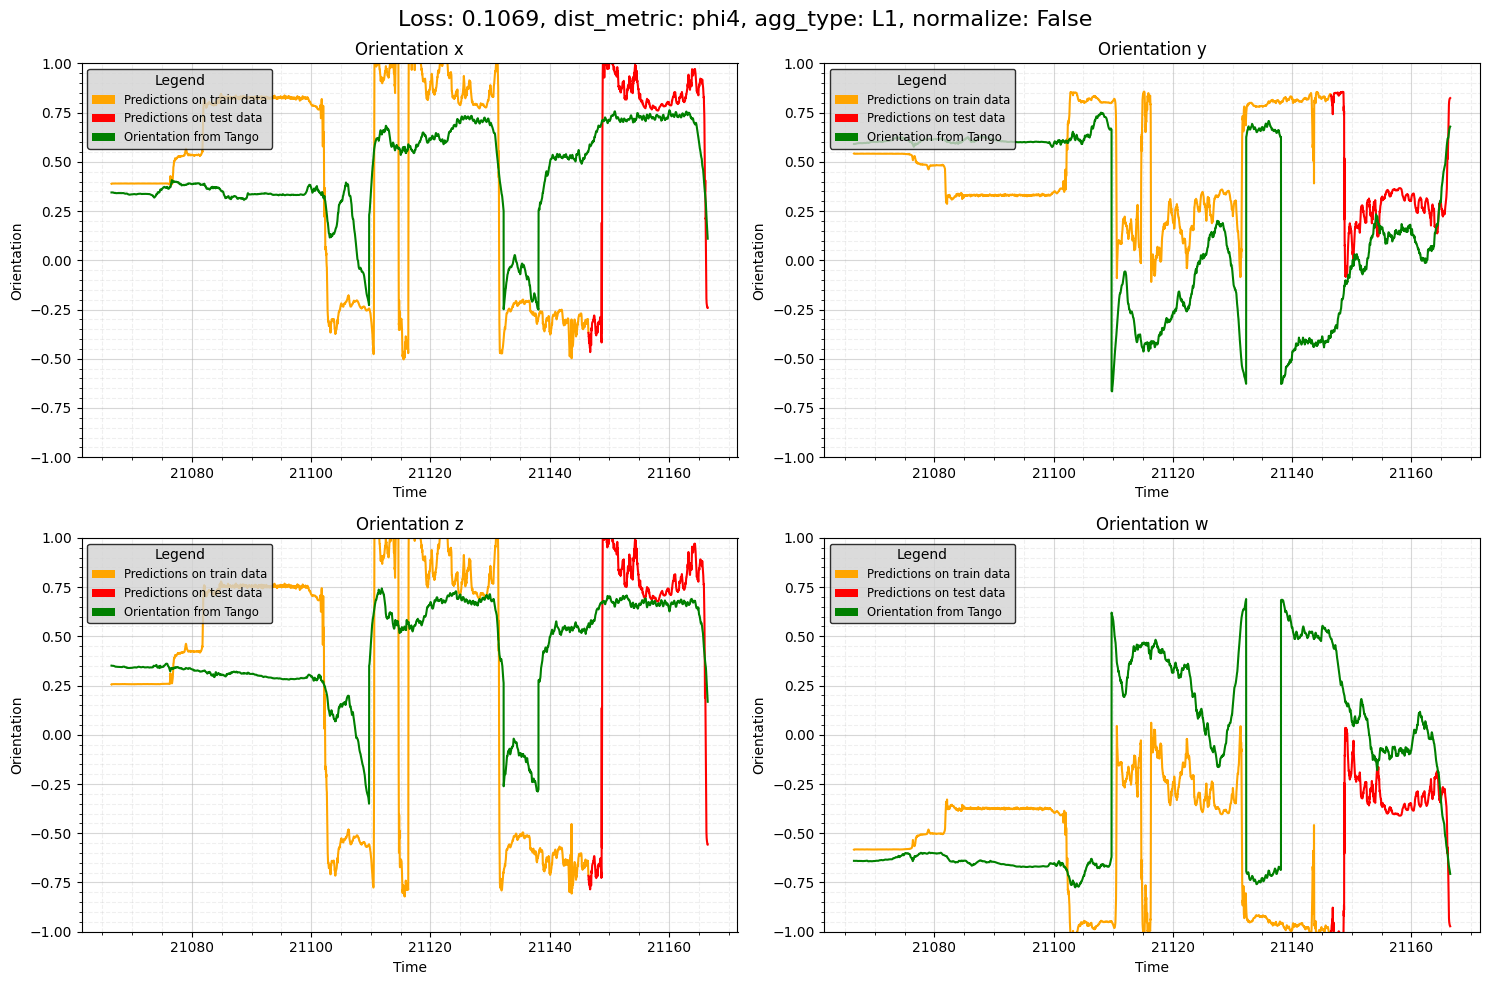

Epoch 1/20, Train Loss: 0.9838, Validation Loss: 0.2032
Epoch 2/20, Train Loss: 0.4220, Validation Loss: 2.8900
Epoch 3/20, Train Loss: 1.1891, Validation Loss: 0.0259
Epoch 4/20, Train Loss: 0.1511, Validation Loss: 0.2582
Epoch 5/20, Train Loss: 0.3136, Validation Loss: 0.2498
Epoch 6/20, Train Loss: 0.2825, Validation Loss: 0.1551
Epoch 7/20, Train Loss: 0.1638, Validation Loss: 0.0553
Epoch 8/20, Train Loss: 0.0623, Validation Loss: 0.0169
Epoch 9/20, Train Loss: 0.0675, Validation Loss: 0.0245
Epoch 10/20, Train Loss: 0.0151, Validation Loss: 0.0337
Epoch 11/20, Train Loss: 0.0173, Validation Loss: 0.0448
Epoch 12/20, Train Loss: 0.0192, Validation Loss: 0.0493
Epoch 13/20, Train Loss: 0.0124, Validation Loss: 0.0437
Epoch 14/20, Train Loss: 0.0086, Validation Loss: 0.0435
Epoch 15/20, Train Loss: 0.0082, Validation Loss: 0.0461
Epoch 16/20, Train Loss: 0.0062, Validation Loss: 0.0436
Epoch 17/20, Train Loss: 0.0055, Validation Loss: 0.0337
Epoch 18/20, Train Loss: 0.0042, Validat

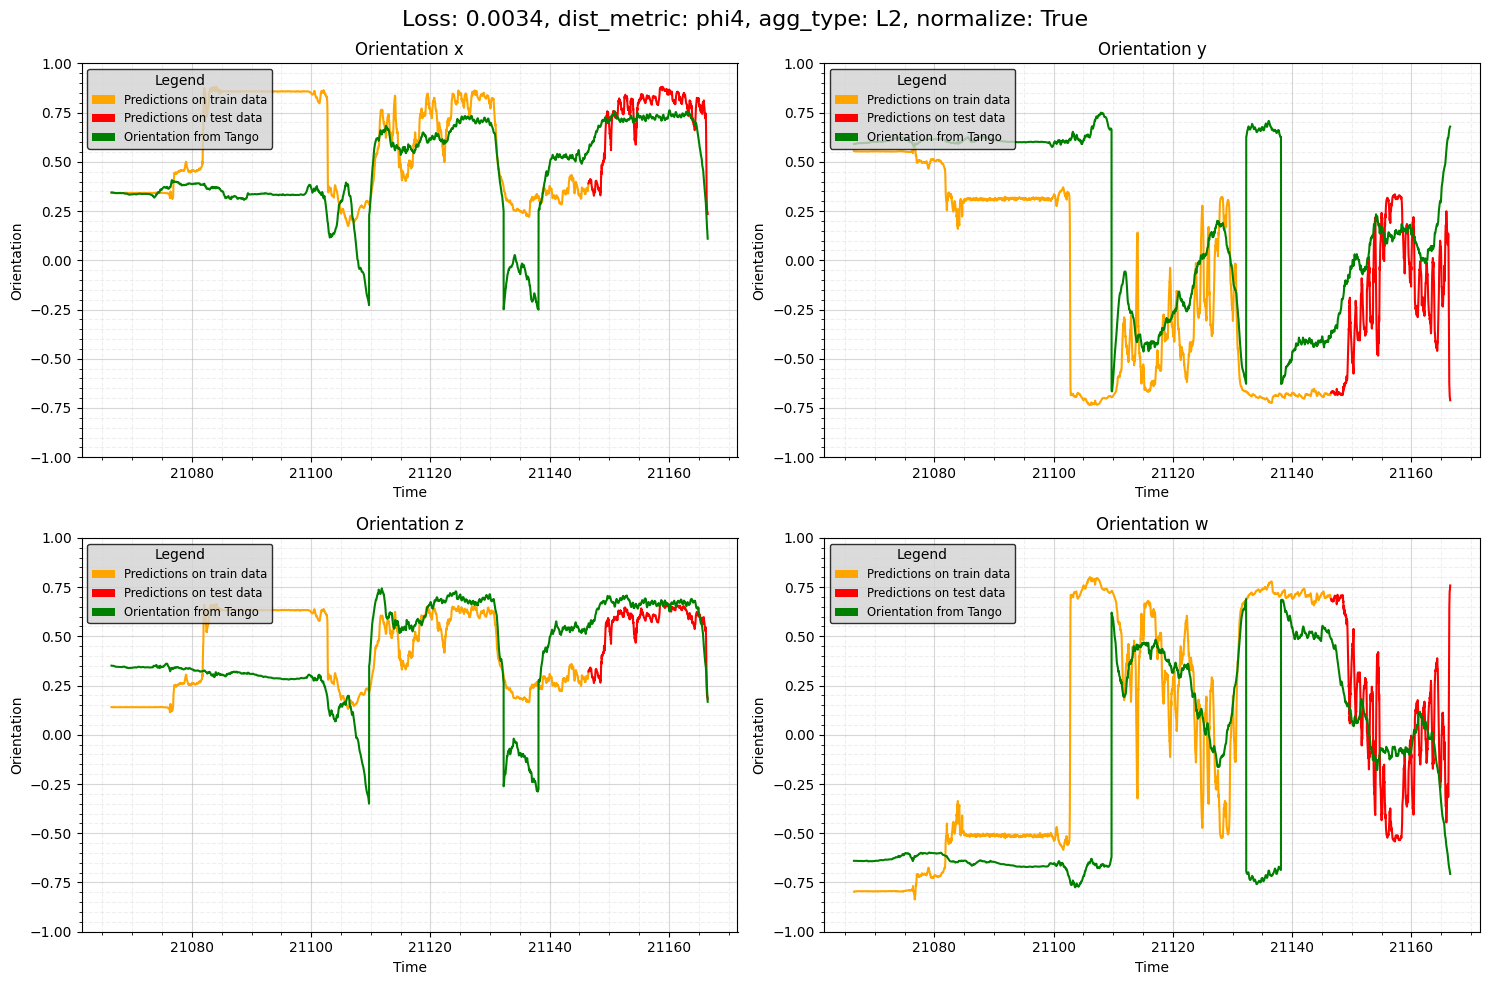

Epoch 1/20, Train Loss: 0.9586, Validation Loss: 0.5168
Epoch 2/20, Train Loss: 0.3668, Validation Loss: 0.5749
Epoch 3/20, Train Loss: 2.5909, Validation Loss: 0.4534
Epoch 4/20, Train Loss: 0.1515, Validation Loss: 0.6091
Epoch 5/20, Train Loss: 0.3669, Validation Loss: 0.4878
Epoch 6/20, Train Loss: 0.3007, Validation Loss: 0.2893
Epoch 7/20, Train Loss: 0.1520, Validation Loss: 0.1965
Epoch 8/20, Train Loss: 0.0949, Validation Loss: 0.2108
Epoch 9/20, Train Loss: 0.0685, Validation Loss: 0.2494
Epoch 10/20, Train Loss: 0.0364, Validation Loss: 0.2595
Epoch 11/20, Train Loss: 0.0428, Validation Loss: 0.2214
Epoch 12/20, Train Loss: 0.0304, Validation Loss: 0.1933
Epoch 13/20, Train Loss: 0.0256, Validation Loss: 0.1863
Epoch 14/20, Train Loss: 0.0181, Validation Loss: 0.1721
Epoch 15/20, Train Loss: 0.0162, Validation Loss: 0.1524
Epoch 16/20, Train Loss: 0.0149, Validation Loss: 0.1472
Epoch 17/20, Train Loss: 0.0129, Validation Loss: 0.1474
Epoch 18/20, Train Loss: 0.0112, Validat

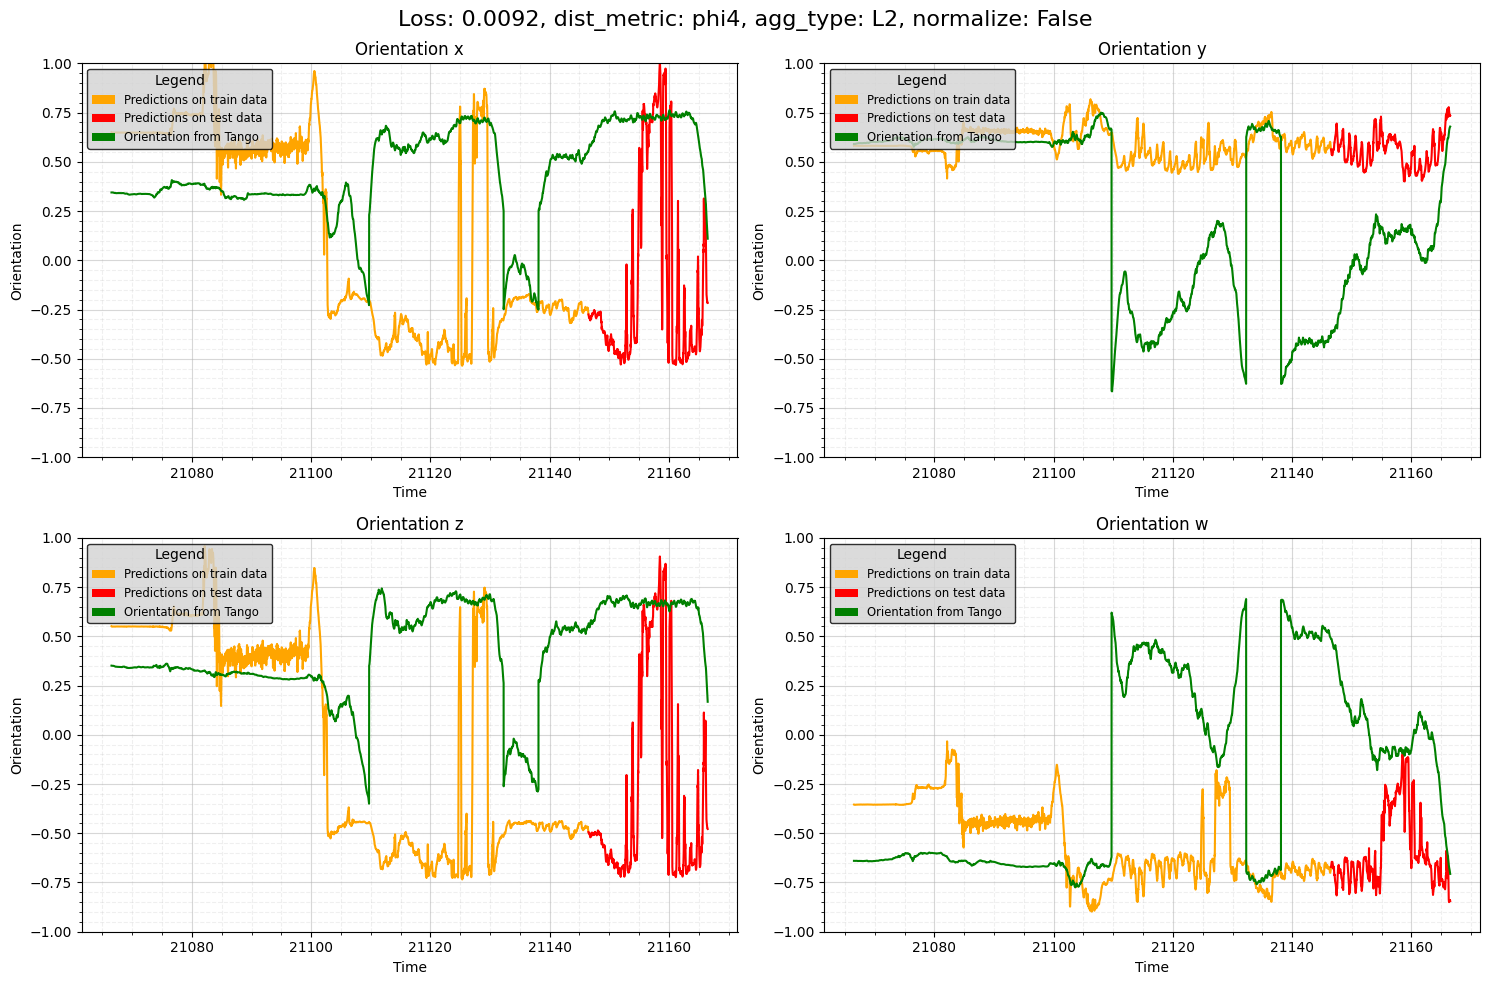

Epoch 1/20, Train Loss: 306.9446, Validation Loss: 168.9807
Epoch 2/20, Train Loss: 250.0798, Validation Loss: 159.6568
Epoch 3/20, Train Loss: 170.0375, Validation Loss: 111.5141
Epoch 4/20, Train Loss: 152.5292, Validation Loss: 114.0306
Epoch 5/20, Train Loss: 110.2697, Validation Loss: 120.5671
Epoch 6/20, Train Loss: 102.5923, Validation Loss: 94.9505
Epoch 7/20, Train Loss: 86.4822, Validation Loss: 68.8525
Epoch 8/20, Train Loss: 168.4200, Validation Loss: 89.1924
Epoch 9/20, Train Loss: 92.6772, Validation Loss: 110.9081
Epoch 10/20, Train Loss: 94.7597, Validation Loss: 115.5571
Epoch 11/20, Train Loss: 95.4567, Validation Loss: 108.2767
Epoch 12/20, Train Loss: 89.6800, Validation Loss: 98.5018
Epoch 13/20, Train Loss: 84.3295, Validation Loss: 92.0935
Epoch 14/20, Train Loss: 80.7163, Validation Loss: 85.3591
Epoch 15/20, Train Loss: 86.1602, Validation Loss: 82.3572
Epoch 16/20, Train Loss: 78.8160, Validation Loss: 71.2190
Epoch 17/20, Train Loss: 62.8722, Validation Loss:

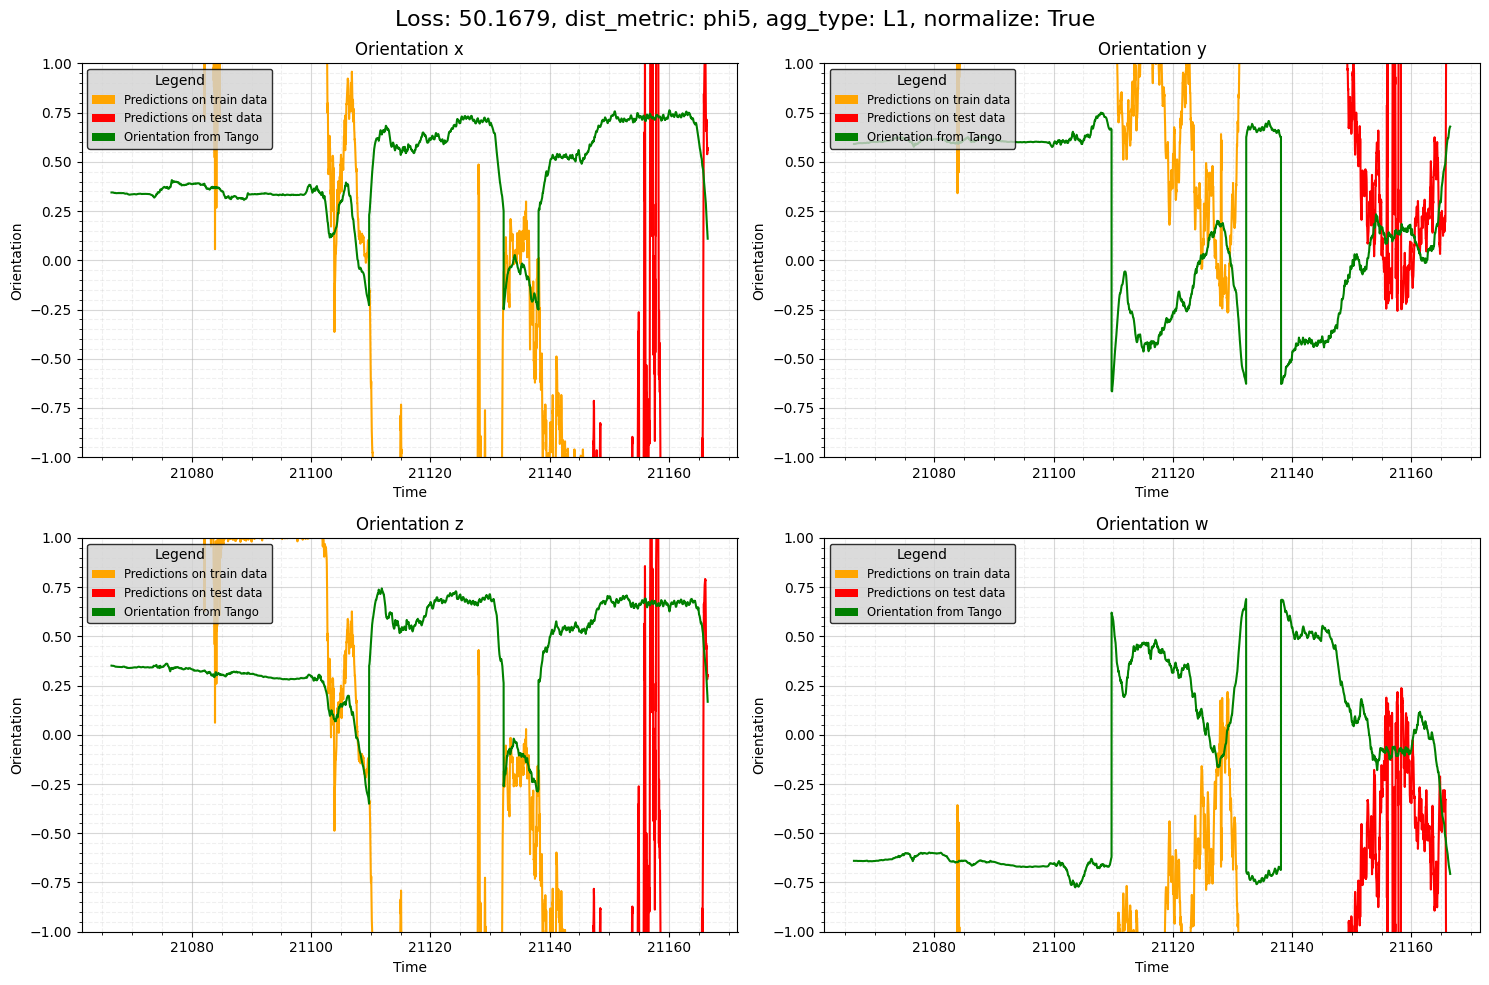

Epoch 1/20, Train Loss: 291.7975, Validation Loss: 170.7635
Epoch 2/20, Train Loss: 261.8993, Validation Loss: 157.2076
Epoch 3/20, Train Loss: 163.5368, Validation Loss: 120.0161
Epoch 4/20, Train Loss: 158.7260, Validation Loss: 131.5595
Epoch 5/20, Train Loss: 119.4630, Validation Loss: 110.9598
Epoch 6/20, Train Loss: 101.0237, Validation Loss: 78.1669
Epoch 7/20, Train Loss: 97.4532, Validation Loss: 86.6175
Epoch 8/20, Train Loss: 86.9749, Validation Loss: 98.4289
Epoch 9/20, Train Loss: 84.4533, Validation Loss: 84.7113
Epoch 10/20, Train Loss: 74.6845, Validation Loss: 77.3791
Epoch 11/20, Train Loss: 72.5000, Validation Loss: 82.8247
Epoch 12/20, Train Loss: 69.7493, Validation Loss: 85.2600
Epoch 13/20, Train Loss: 63.0417, Validation Loss: 78.6453
Epoch 14/20, Train Loss: 61.2473, Validation Loss: 75.1506
Epoch 15/20, Train Loss: 57.3157, Validation Loss: 61.2069
Epoch 16/20, Train Loss: 85.7239, Validation Loss: 103.6578
Epoch 17/20, Train Loss: 86.2196, Validation Loss: 10

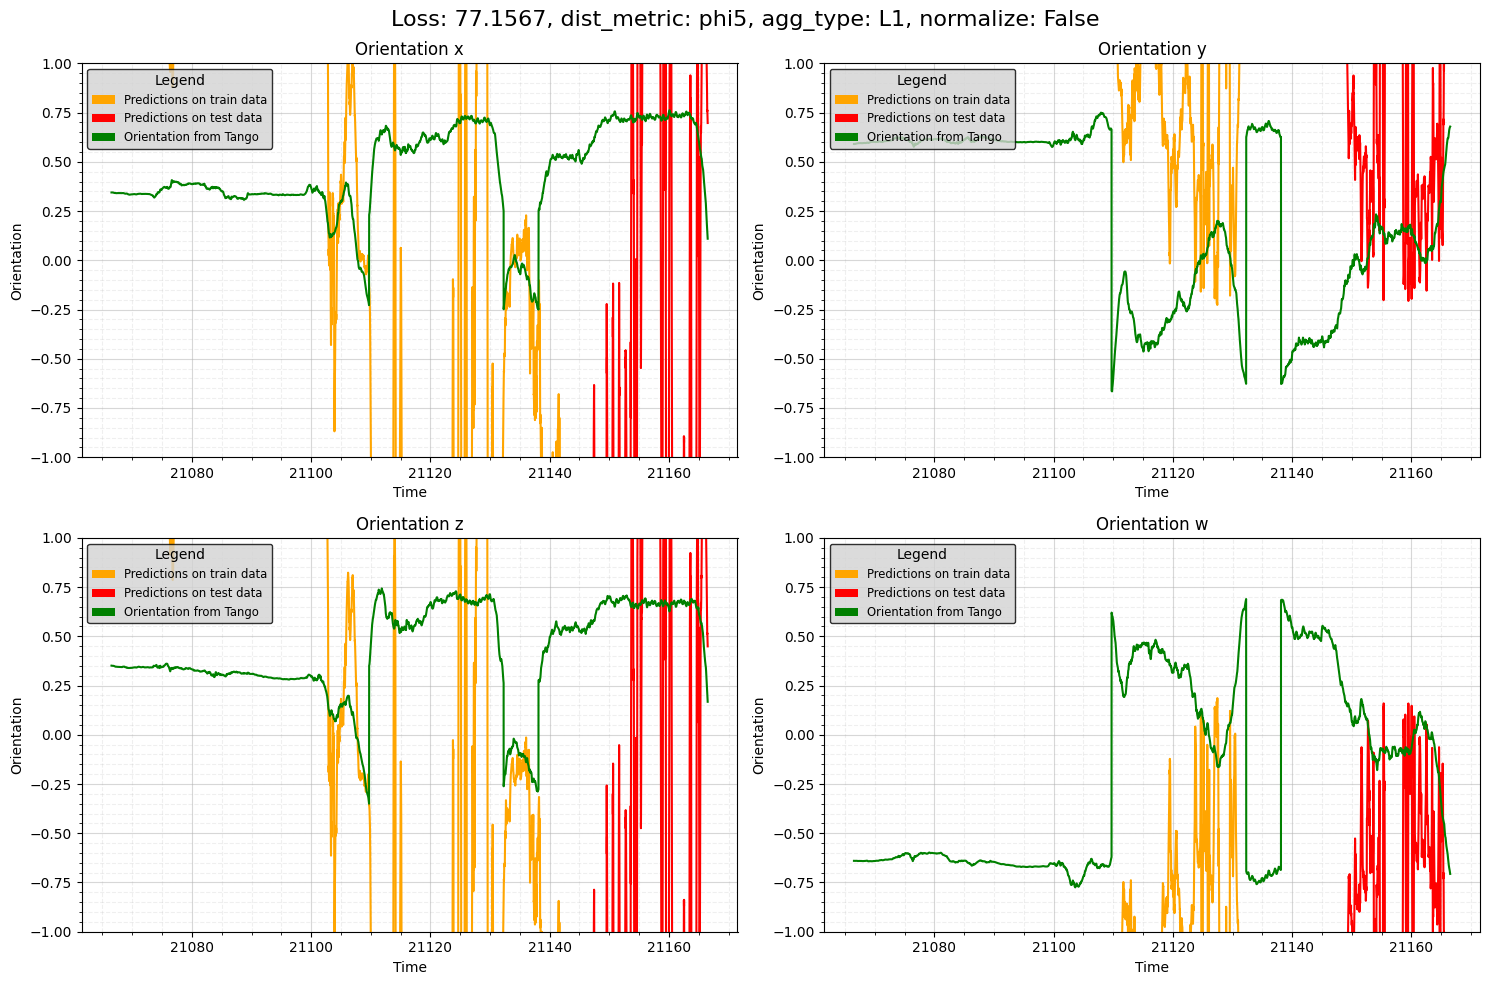

Epoch 1/20, Train Loss: 112984.1406, Validation Loss: 8620.0127
Epoch 2/20, Train Loss: 55280.4062, Validation Loss: 9893.9414
Epoch 3/20, Train Loss: 24587.1641, Validation Loss: 14405.9805
Epoch 4/20, Train Loss: 17487.8379, Validation Loss: 9741.3389
Epoch 5/20, Train Loss: 11680.4238, Validation Loss: 6394.1431
Epoch 6/20, Train Loss: 8632.9561, Validation Loss: 7329.1870
Epoch 7/20, Train Loss: 9213.3516, Validation Loss: 8190.2153
Epoch 8/20, Train Loss: 6611.7324, Validation Loss: 7389.0610
Epoch 9/20, Train Loss: 6179.1821, Validation Loss: 7143.9702
Epoch 10/20, Train Loss: 5690.2617, Validation Loss: 6697.3066
Epoch 11/20, Train Loss: 4856.0923, Validation Loss: 5512.5889
Epoch 12/20, Train Loss: 4322.8960, Validation Loss: 5538.6270
Epoch 13/20, Train Loss: 3597.5002, Validation Loss: 6040.7554
Epoch 14/20, Train Loss: 3412.6982, Validation Loss: 4635.9658
Epoch 15/20, Train Loss: 2821.3428, Validation Loss: 4879.2515
Epoch 16/20, Train Loss: 2355.6548, Validation Loss: 5190

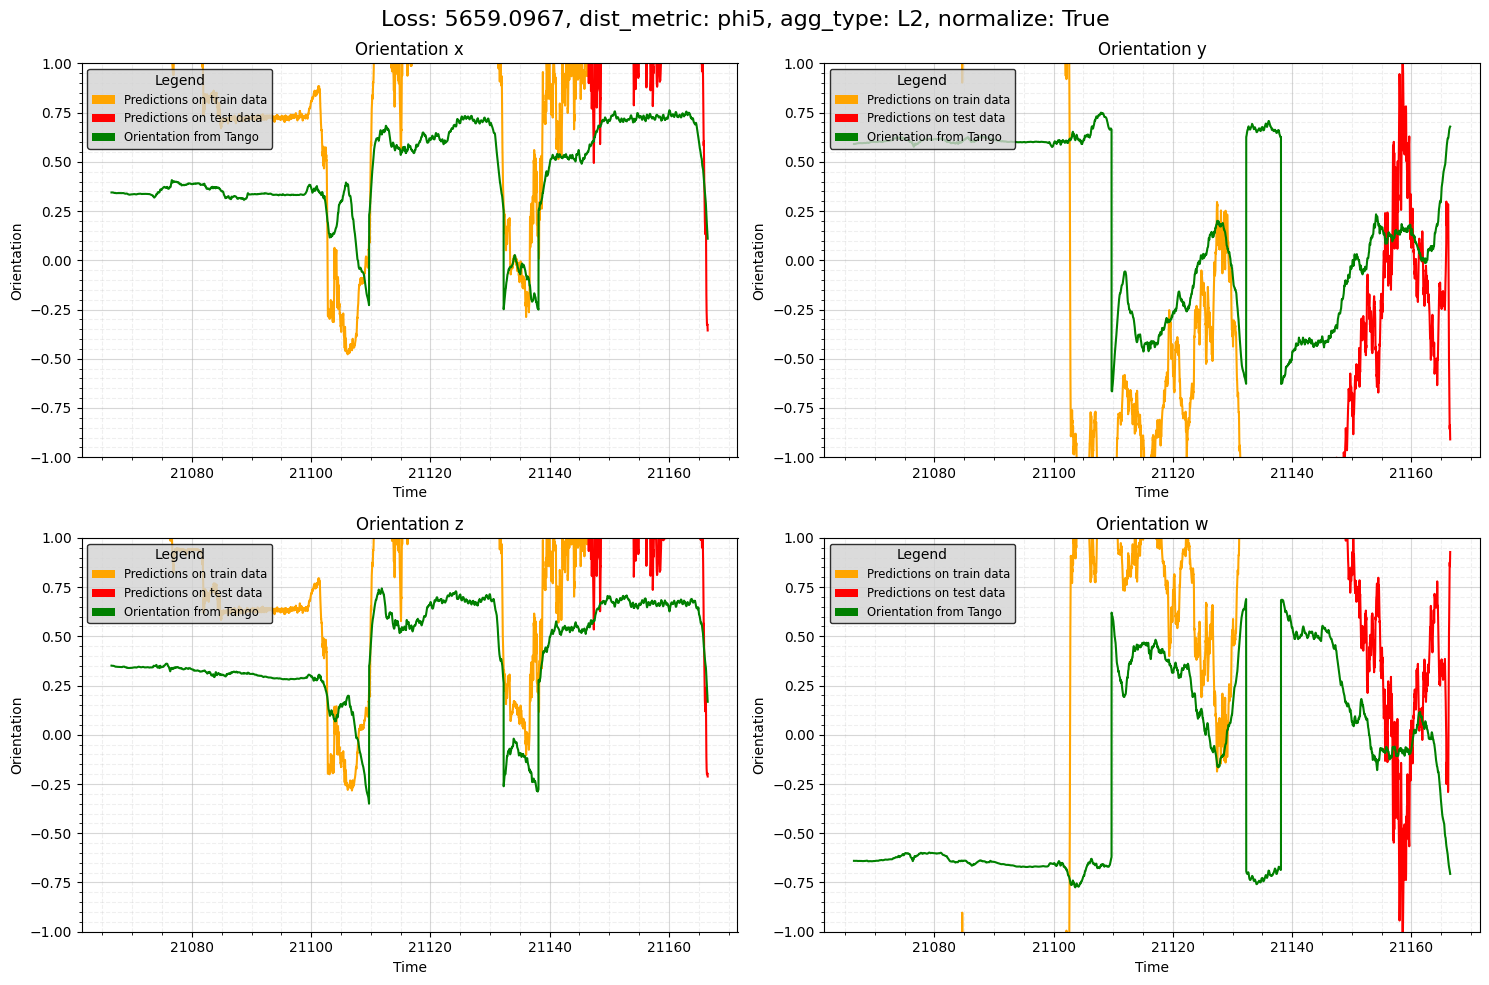

Epoch 1/20, Train Loss: 84567.9531, Validation Loss: 26441.5859
Epoch 2/20, Train Loss: 80667.0234, Validation Loss: 14943.8594
Epoch 3/20, Train Loss: 56716.1953, Validation Loss: 15384.7334
Epoch 4/20, Train Loss: 30412.6973, Validation Loss: 15405.3926
Epoch 5/20, Train Loss: 16394.4043, Validation Loss: 11196.2979
Epoch 6/20, Train Loss: 9578.3311, Validation Loss: 7410.1753
Epoch 7/20, Train Loss: 11251.9873, Validation Loss: 11315.4033
Epoch 8/20, Train Loss: 9861.8115, Validation Loss: 7800.1987
Epoch 9/20, Train Loss: 8412.6357, Validation Loss: 7467.5327
Epoch 10/20, Train Loss: 7085.7612, Validation Loss: 6670.7026
Epoch 11/20, Train Loss: 5383.3667, Validation Loss: 6764.8882
Epoch 12/20, Train Loss: 5359.5801, Validation Loss: 6826.1948
Epoch 13/20, Train Loss: 4745.9941, Validation Loss: 6562.0742
Epoch 14/20, Train Loss: 4255.7080, Validation Loss: 6656.6597
Epoch 15/20, Train Loss: 3865.1372, Validation Loss: 5303.2412
Epoch 16/20, Train Loss: 4341.8481, Validation Loss:

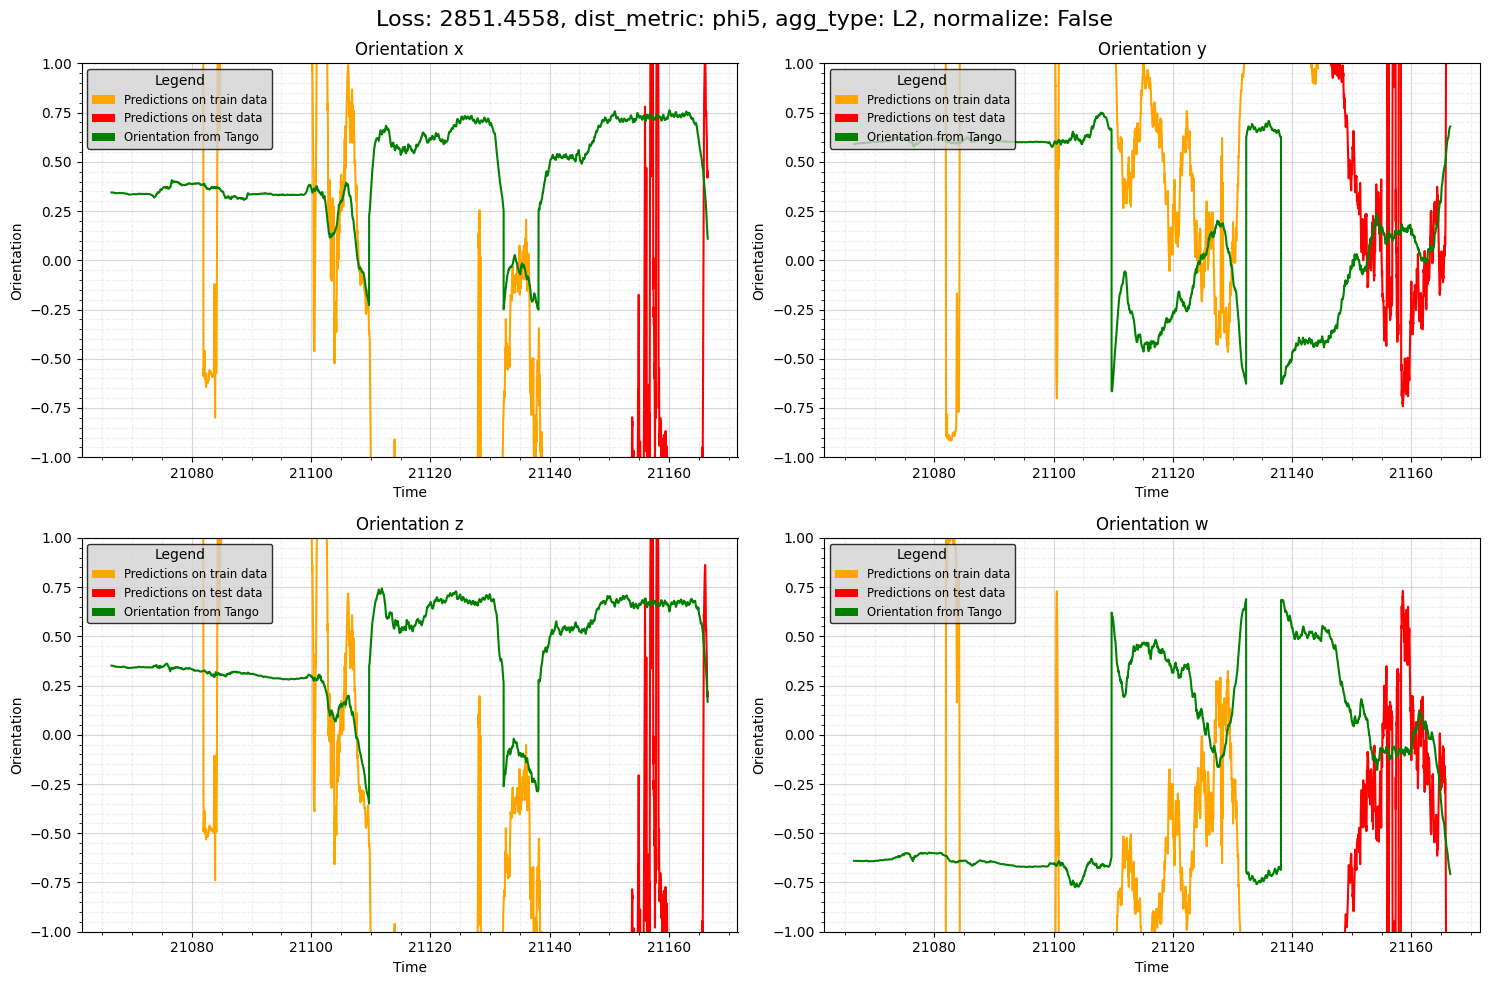

ValueError: Invalid distance metric

In [5]:
for dist_metric, agg_type, normal in itertools.product(['phi2', 'phi4', 'phi5'], ['L1', 'L2'], [True, False]):

    train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

    input_size = train_data.shape[1]

    train_data = train_data.view(num_samples, -1, input_size)
    train_labels = tango_ori

    train_size = int(0.8*len(train_data))
    valid_size = len(train_data) - train_size

    valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
    train_data, train_labels = train_data[:train_size], train_labels[:train_size]

    train_data = train_data.view(train_size, -1, input_size)
    valid_data = valid_data.view(valid_size, -1, input_size)

    model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
    model.to('cpu')
    criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type, normal=normal)

    optimizer = optim.AdamW(model.parameters(), betas=betas, lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_data)
        loss = criterion(outputs, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            valid_outputs = model(valid_data)
            valid_loss = criterion(valid_outputs, valid_labels)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

    print("Finished Training")

    full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)
    full_data = full_data.view(num_samples, -1, input_size)

    model.eval()
    with torch.no_grad():
        predictions = model(full_data.to('cpu'))

    plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)

In [ ]:
num_epochs = 100

train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

input_size = train_data.shape[1]

train_data = train_data.view(num_samples, -1, input_size)
train_labels = tango_ori

train_size = int(0.8*len(train_data))
valid_size = len(train_data) - train_size

valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
train_data, train_labels = train_data[:train_size], train_labels[:train_size]

train_data = train_data.view(train_size, -1, input_size)
valid_data = valid_data.view(valid_size, -1, input_size)

model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu')
criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

optimizer = optim.AdamW(model.parameters(), betas=betas, lr=learning_rate, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_data)
        valid_loss = criterion(valid_outputs, valid_labels)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

print("Finished Training")

full_data = torch.cat((gyro, acc, mag, rv, game_rv, Q_1, Q_2, Q_ekf), dim=1)
full_data = full_data.view(num_samples, -1, input_size)

model.eval()
with torch.no_grad():
    predictions = model(full_data.to('cpu'))

plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)

## including rv and game_rv

torch.Size([20000, 29])
Epoch 1/200, Train Loss: 1.0342, Validation Loss: 0.3570
Epoch 2/200, Train Loss: 0.5521, Validation Loss: 1.7424
Epoch 3/200, Train Loss: 1.8669, Validation Loss: 0.7108
Epoch 4/200, Train Loss: 0.4676, Validation Loss: 0.8232
Epoch 5/200, Train Loss: 0.4729, Validation Loss: 0.7449
Epoch 6/200, Train Loss: 0.3770, Validation Loss: 0.5815
Epoch 7/200, Train Loss: 0.2632, Validation Loss: 0.3857
Epoch 8/200, Train Loss: 0.1740, Validation Loss: 0.2384
Epoch 9/200, Train Loss: 0.1348, Validation Loss: 0.1929
Epoch 10/200, Train Loss: 0.1226, Validation Loss: 0.2328
Epoch 11/200, Train Loss: 0.0979, Validation Loss: 0.1847
Epoch 12/200, Train Loss: 0.0728, Validation Loss: 0.1771
Epoch 13/200, Train Loss: 0.0765, Validation Loss: 0.1340
Epoch 14/200, Train Loss: 0.1031, Validation Loss: 0.2804
Epoch 15/200, Train Loss: 0.1208, Validation Loss: 0.1219
Epoch 16/200, Train Loss: 0.0797, Validation Loss: 0.1167
Epoch 17/200, Train Loss: 0.0674, Validation Loss: 0.1809

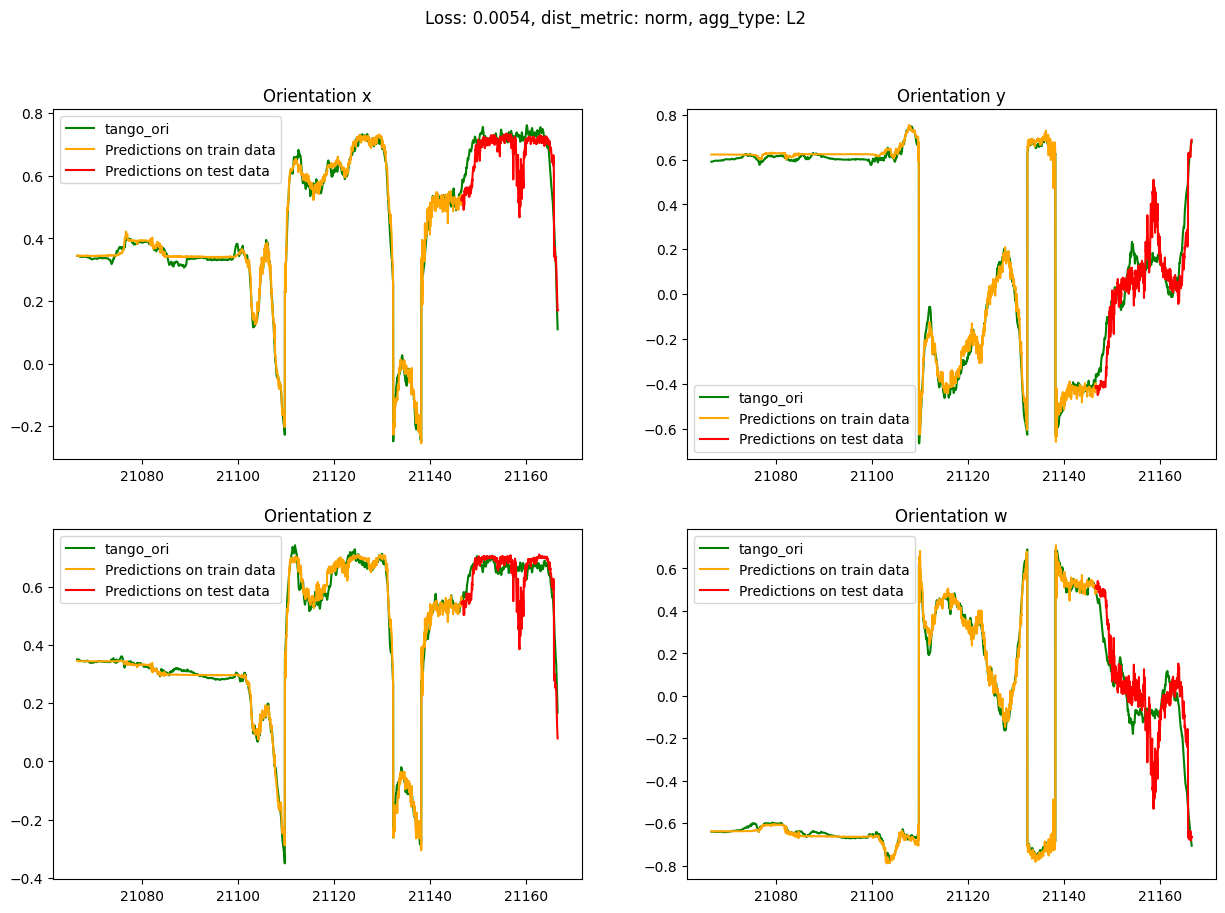

In [ ]:
input_size = 29

train_data = torch.cat((gyro, acc, mag, rv, game_rv, Q_1, Q_2, Q_ekf), dim=1)

print(train_data.shape)

input_size = train_data.shape[1]

train_data = train_data.view(num_samples, -1, input_size)
train_labels = tango_ori

train_size = int(0.8*len(train_data))
valid_size = len(train_data) - train_size

valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
train_data, train_labels = train_data[:train_size], train_labels[:train_size]

train_data = train_data.view(train_size, -1, input_size)
valid_data = valid_data.view(valid_size, -1, input_size)

model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu')
criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

optimizer = optim.AdamW(model.parameters(), betas=betas, lr=learning_rate, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_data)
        valid_loss = criterion(valid_outputs, valid_labels)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

print("Finished Training")

full_data = torch.cat((gyro, acc, mag, rv, game_rv, Q_1, Q_2, Q_ekf), dim=1)
full_data = full_data.view(num_samples, -1, input_size)

model.eval()
with torch.no_grad():
    predictions = model(full_data.to('cpu'))

plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)